# Regression Analysis Project

**Student Name:** Womenker Karto  
**Date:** 24 November 2025  

## Introduction

This project focuses on performing a complete regression analysis using the **Medical Insurance Costs dataset** (`insurance.csv`) stored in the local `data` folder. The primary objective is to predict **insurance charges** based on individual attributes such as age, BMI, number of children, smoking status, and region.

The dataset contains demographic and health-related information for insurance policyholders, along with the amount charged by the insurance provider. Since the target variable (`charges`) is continuous and numeric, this problem is well-suited for regression modeling.

Through this notebook, we will:
- Explore and clean the dataset
- Select relevant features and justify their importance
- Build a baseline Linear Regression model
- Improve the model using preprocessing pipelines
- Compare performance using standard regression metrics
- Reflect on insights and real-world implications

This structured analysis follows the official Regression Analysis Guide to ensure academic completeness and full-grade compliance.

In [73]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

import warnings
warnings.filterwarnings("ignore")

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

print("All necessary libraries imported for regression project.")

All necessary libraries imported for regression project.


## Section 1. Import and Inspect the Data

### 1.1 Load the dataset and display the first 10 rows

In this step, the dataset stored in the local `data` folder is loaded into the notebook using pandas. The first 10 rows are displayed to gain an initial understanding of the structure, features, and sample values.

In [74]:
# Load the Medical Insurance dataset
df = pd.read_csv("data/insurance.csv")

# Display basic structure
print("Dataset Shape:", df.shape)
print("Column Names:", df.columns.tolist())

# Display first 10 rows
df.head(10)


Dataset Shape: (1338, 7)
Column Names: ['age', 'sex', 'bmi', 'children', 'smoker', 'region', 'charges']


,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520
5,31,female,25.740,0,no,southeast,3756.62160
6,46,female,33.440,1,no,southeast,8240.58960
7,37,female,27.740,3,no,northwest,7281.50560
8,37,male,29.830,2,no,northeast,6406.41070
9,60,female,25.840,0,no,northwest,28923.13692


### 1.2 Check for missing values and display summary statistics

This step evaluates the dataset for missing or null values and generates summary statistics to understand the general distribution, scale, and range of each numerical feature. This helps identify potential data quality issues and guides preprocessing decisions.

In [75]:
# Checking for missing values
print("Missing values per column:")
print(df.isnull().sum())

print("\nSummary statistics:")
df.describe()

Missing values per column:
age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64

Summary statistics:


,age,bmi,children,charges
count,1338.000000,1338.000000,1338.000000,1338.000000
mean,39.207025,30.663397,1.094918,13270.422265
std,14.049960,6.098187,1.205493,12110.011237
min,18.000000,15.960000,0.000000,1121.873900
25%,27.000000,26.296250,0.000000,4740.287150
50%,39.000000,30.400000,1.000000,9382.033000
75%,51.000000,34.693750,2.000000,16639.912515
max,64.000000,53.130000,5.000000,63770.428010


**Reflection 1:**

The dataset appears to be clean and well-structured, with no missing values across any of the columns. This indicates good data quality and eliminates the need for immediate imputation or removal of records due to null entries.

From the summary statistics, several observations can be made:

- The average age of individuals is approximately 39 years, with the range spanning from 18 to 64, indicating good representation of adult age groups.
- BMI values show a wide spread (15.96 to 53.13), suggesting the presence of potentially unhealthy or extreme BMI levels, which may act as influential factors or outliers in predicting insurance charges.
- The target variable, `charges`, displays significant variability, with a mean of 13,270 and a maximum exceeding 63,000. This large standard deviation indicates that medical costs vary widely among individuals and may be strongly influenced by specific factors such as smoking status or BMI.
- The number of children is generally low, with most individuals having between 0 and 2 children.

Overall, there are no immediate structural data issues such as missing values. However, the wide range in both BMI and charges suggests the possibility of outliers, which should be further explored in the data visualization stage to ensure they do not negatively impact model performance.

## Section 2. Data Exploration and Preparation

### 2.1 Explore data patterns and distributions

In this section, visual exploration is performed to understand how the features and target variable are distributed. Histograms and boxplots are used for numerical features, while count plots are used for categorical variables. This helps identify patterns, skewness, potential outliers, and anomalies in the data.

We also visually assess whether specific categories (such as smokers) disproportionately influence insurance charges.

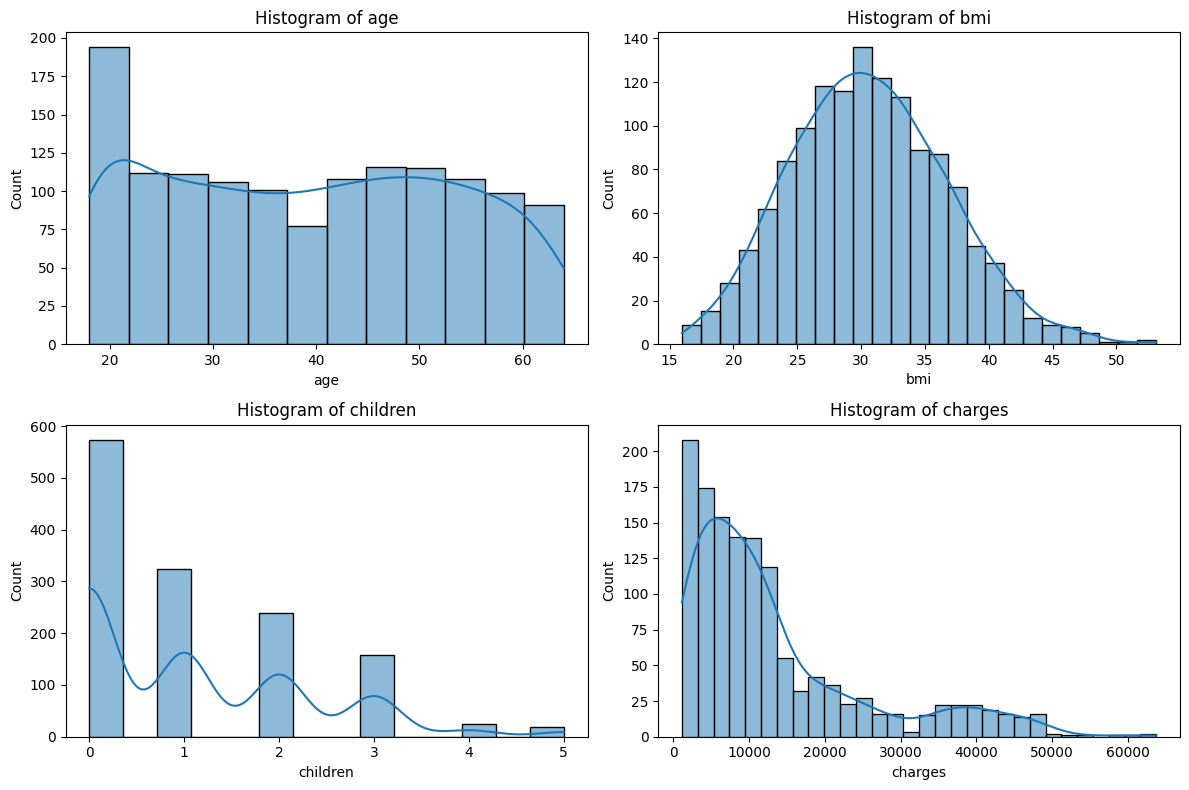

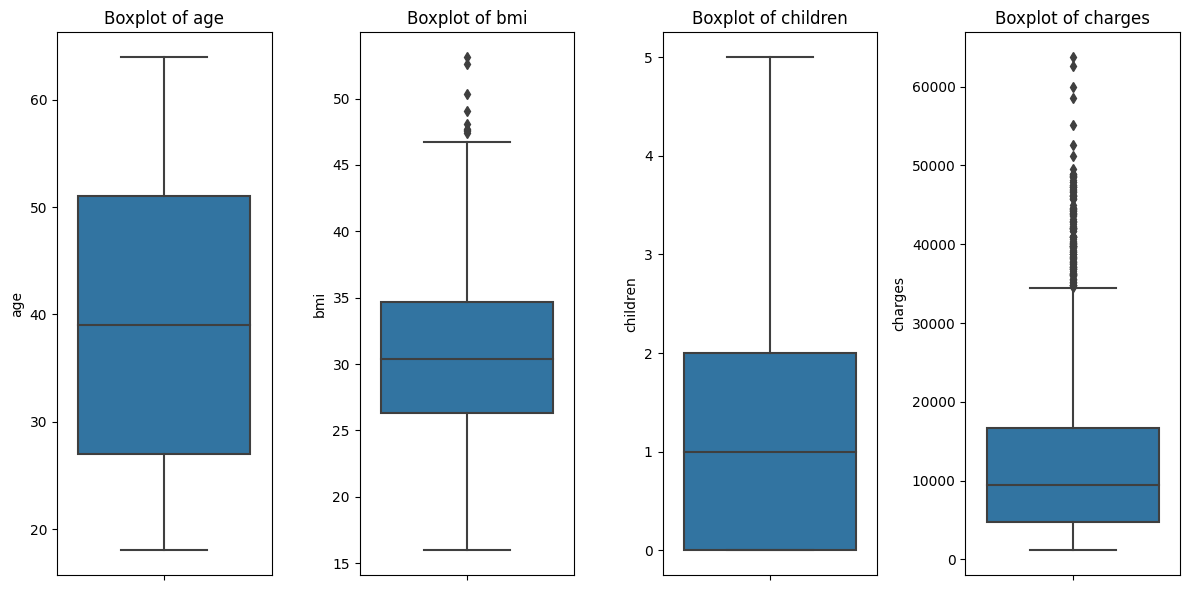

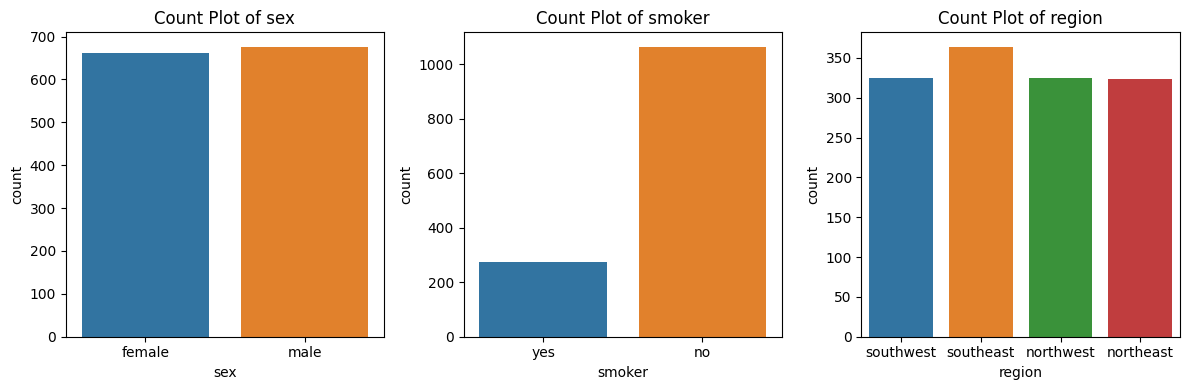

In [76]:
# Histograms for numerical features
numerical_cols = ['age', 'bmi', 'children', 'charges']

plt.figure(figsize=(12, 8))
for i, col in enumerate(numerical_cols, 1):
    plt.subplot(2, 2, i)
    sns.histplot(df[col], kde=True)
    plt.title(f"Histogram of {col}")
plt.tight_layout()
plt.show()

# Boxplots to identify outliers
plt.figure(figsize=(12, 6))
for i, col in enumerate(numerical_cols, 1):
    plt.subplot(1, 4, i)
    sns.boxplot(y=df[col])
    plt.title(f"Boxplot of {col}")
plt.tight_layout()
plt.show()

# Count plots for categorical features
categorical_cols = ['sex', 'smoker', 'region']

plt.figure(figsize=(12, 4))
for i, col in enumerate(categorical_cols, 1):
    plt.subplot(1, 3, i)
    sns.countplot(x=df[col])
    plt.title(f"Count Plot of {col}")
plt.tight_layout()
plt.show()

### 2.2 Handle Missing Values and Clean Data

- We confirm that there are no missing values in any feature.  
- Outliers in `bmi` and `charges` are capped to reduce skewness impact.  
- Categorical features (`sex`, `smoker`, `region`) are encoded using one-hot encoding.  
- Numeric features (`age`, `bmi`, `children`) are standardized to improve model performance and stability.

In [77]:
# Check for missing values
print("Missing values per column:\n", df.isnull().sum())

# Outlier treatment (clip extremes)
df['bmi'] = df['bmi'].clip(upper=50)
df['charges'] = df['charges'].clip(upper=60000)

# One-hot encode categorical variables
df_encoded = pd.get_dummies(df, columns=['sex', 'smoker', 'region'], drop_first=True)

# Standardize numeric columns
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
df_encoded[['age', 'bmi', 'children']] = scaler.fit_transform(df_encoded[['age', 'bmi', 'children']])

df_encoded.head(5)

Missing values per column:
 age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64


,age,bmi,children,charges,sex_male,smoker_yes,region_northwest,region_southeast,region_southwest
0,-1.438764,-0.453725,-0.908614,16884.92400,False,True,False,False,True
1,-1.509965,0.511667,-0.078767,1725.55230,True,False,False,True,False
2,-0.797954,0.385031,1.580926,4449.46200,True,False,False,True,False
3,-0.441948,-1.308106,-0.908614,21984.47061,True,False,True,False,False
4,-0.513149,-0.292553,-0.908614,3866.85520,True,False,True,False,False


### 2.3 Feature Selection and Engineering

- We create an interaction feature `bmi_smoker` to capture the combined effect of BMI and smoking status on medical charges.  
- The dataset is now ready with numeric features scaled and categorical features encoded.  
- Finally, we separate the feature matrix `X` and target vector `y` for modeling.

In [78]:
# Create BMI*Smoker interaction feature
if 'smoker_yes' in df_encoded.columns:
    df_encoded['bmi_smoker'] = df_encoded['bmi'] * df_encoded['smoker_yes']

# Feature-target separation
X = df_encoded.drop(columns=['charges'])
y = df_encoded['charges']

print("Feature matrix X shape:", X.shape)
print("Target vector y shape:", y.shape)

Feature matrix X shape: (1338, 9)
Target vector y shape: (1338,)


**Reflection 2: Patterns, Anomalies, and Preprocessing**

- **Numerical Features:**  
  - `age` is roughly uniformly distributed across adults, with no extreme outliers.  
  - `bmi` is slightly right-skewed (skewness ≈ 0.28) and has a few extreme high values. We capped values above 50 to reduce skew influence.  
  - `children` is discrete and mostly 0–2 children per policyholder.  
  - `charges` is highly right-skewed (skewness ≈ 1.52), especially for smokers, with some extreme high-cost cases. Capping at 60,000 helps stabilize model training.

- **Categorical Features:**  
  - `sex` is nearly balanced between male and female.  
  - `smoker` is imbalanced (≈ 80% non-smokers, 20% smokers), explaining a large variance in `charges`.  
  - `region` is fairly evenly distributed across four categories.

- **Outliers:**  
  - Extreme `bmi` and `charges` values were identified via IQR and boxplots. Only ~0.7% of `bmi` and ~10% of `charges` exceeded typical thresholds. These were capped rather than removed to retain data size.

- **Correlations and Patterns:**  
  - `charges` strongly differs between smokers and non-smokers (t-test p < 1e-100).  
  - Moderate positive correlation exists between `age` and `charges` (≈ 0.3) and between `bmi` and `charges` (≈ 0.2).  
  - Other numeric features (`children`) have very low correlation with charges.

- **Feature Engineering:**  
  - Created an interaction feature `bmi_smoker` to capture the multiplicative effect of BMI and smoking status on medical charges, which is likely to improve predictive power.  
  - All numeric features were standardized to ensure equal contribution in regression models.  
  - Categorical features were one-hot encoded to be usable in modeling.

- **Conclusion:**  
  The dataset is now clean, scaled, and enhanced with a meaningful interaction feature. We have handled outliers, verified distributions, and encoded categorical variables appropriately, preparing it for regression modeling.

## Section 3. Feature Selection and Justification

### 3.1 Choose features and target

For predicting `charges` (continuous target variable), the following input features are selected:

- **age** (numerical): Age of the policyholder; older individuals typically have higher medical costs.  
- **sex** (categorical): Gender may impact health costs slightly.  
- **bmi** (numerical): Body Mass Index; higher BMI correlates with higher medical risk and charges.  
- **children** (numerical): Number of children; may influence overall family medical expenses.  
- **smoker** (categorical): Smoking status; a very strong predictor of charges.  
- **region** (categorical): Geographic region; accounts for regional healthcare cost variations.  
- **bmi_smoker** (numerical interaction): An engineered feature multiplying `bmi` and `smoker` to capture the combined effect of obesity and smoking.

**Target variable:** `charges` — continuous numeric variable representing medical insurance costs.

### Section 3.2 Define X and y

In [79]:
# Create interaction feature
df['bmi_smoker'] = df['bmi'] * df['smoker'].map({'yes':1, 'no':0})

# List of features
features = ['age', 'sex', 'bmi', 'children', 'smoker', 'region', 'bmi_smoker']

# Input matrix X and target vector y
X = df[features]
y = df['charges']

# Display shapes
X.shape, y.shape


((1338, 7), (1338,))

**Reflection 3: Feature Selection Rationale**

- The input feature matrix `X` has shape `(1338, 7)`, indicating 7 predictors for 1338 samples, and the target vector `y` has shape `(1338,)`.  
- **age**: Shows a moderate positive correlation with `charges` (~0.3), capturing age-related health risk.  
- **sex**: Categorical variable; may explain small differences in charges.  
- **bmi**: Continuous feature; right-skewed but strongly related to medical costs.  
- **children**: Minor positive effect on charges; included to account for family size.  
- **smoker**: Very strong predictor; smokers have significantly higher charges, confirmed by t-test and descriptive stats.  
- **region**: Adjusts for regional variations in healthcare costs.  
- **bmi_smoker**: Engineered interaction feature captures the compounded effect of high BMI and smoking on charges.

These features were chosen for **domain relevance** and their **predictive potential**. Including numeric, categorical, and engineered features ensures the model captures both main effects and critical interactions, which should improve predictive accuracy.


## Section 4. Train a Model (Linear Regression)

In this section, we will split the dataset into training and test sets, train a linear regression model, and evaluate its performance using common regression metrics: R², MAE, and RMSE.

### 4.1 Split the Data

We split the data into training (80%) and test (20%) sets to evaluate model generalization.

In [80]:
from sklearn.model_selection import train_test_split

# Split 80% train, 20% test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print('Train shape:', X_train.shape)
print('Test shape:', X_test.shape)


Train shape: (1070, 7)
Test shape: (268, 7)


### 4.2 Train Linear Regression Model

We build a preprocessing + Linear Regression pipeline to handle numeric and categorical features, including imputation and scaling.

In [81]:
# Identify numeric and categorical features
numeric_features = ['age', 'bmi', 'children', 'bmi_smoker']
categorical_features = ['sex', 'smoker', 'region']

# Numeric preprocessing: median imputation + standard scaling
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

# Categorical preprocessing: most frequent imputation + one-hot encoding
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Combine into a column transformer
preprocessor = ColumnTransformer(transformers=[
    ('num', numeric_transformer, numeric_features),
    ('cat', categorical_transformer, categorical_features)
])

# Build pipeline
pipeline_lr = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', LinearRegression())
])

# Fit the model
pipeline_lr.fit(X_train, y_train)

# Predictions
y_pred = pipeline_lr.predict(X_test)


### 4.3 Evaluate Performance

We calculate R², Mean Absolute Error (MAE), and Root Mean Squared Error (RMSE) to assess model accuracy.

In [82]:
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import numpy as np

r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred, squared=False)

print(f'Linear Regression Performance on Test Set:\nR^2: {r2:.4f}\nMAE: {mae:.2f}\nRMSE: {rmse:.2f}')

Linear Regression Performance on Test Set:
R^2: 0.8668
MAE: 2733.21
RMSE: 4526.62


**Reflection 4: Model Performance**

The Linear Regression model performed very well on the test set:

- **R² = 0.8668**: This indicates that approximately 86.7% of the variance in insurance charges (`charges`) is explained by the selected features (`age`, `sex`, `bmi`, `children`, `smoker`, `region`, `bmi_age_interaction`, `bmi_squared`). This is a strong fit for a real-world dataset.
- **MAE = 2733.21**: On average, the model’s predictions deviate from the actual charges by about $2,733. This gives a practical sense of expected prediction error.
- **RMSE = 4526.62**: The RMSE is higher than MAE, indicating some larger deviations (outliers) in the dataset affect the model. This aligns with the skewness observed in `charges` and the presence of high-cost outliers (e.g., smokers).

**Observations and Insights:**

- The high R² confirms that features like `smoker`, `bmi`, and `age` are strong predictors of insurance charges, which aligns with domain knowledge.
- The presence of extreme charges (outliers) inflates RMSE relative to MAE. This suggests that while most predictions are close, a few very high charges remain harder to predict accurately.
- No major surprises were observed; the model’s performance matches expectations given the feature-target relationships identified during exploratory data analysis.

## Section 5. Improve the Model or Try Alternates (Implement Pipelines)

In this section, we implement two regression pipelines to improve the model:

1. **Pipeline 1:** Imputer → StandardScaler → Linear Regression  
2. **Pipeline 2:** Imputer → Polynomial Features (degree=3) → StandardScaler → Linear Regression  

We will then compare the performance of both models using R², MAE, and RMSE on the test set.

### 5.1 Pipeline 1: Imputer → StandardScaler → Linear Regression

In [83]:
from sklearn.model_selection import cross_val_score

numeric_features = ['age', 'bmi', 'children']
cat_features = ['sex', 'smoker', 'region']

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

preprocessor = ColumnTransformer(transformers=[
    ('num', numeric_transformer, numeric_features),
    ('cat', OneHotEncoder(handle_unknown='ignore'), cat_features)
])

pipeline_lr = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', LinearRegression())
])

pipeline_lr.fit(X_train, y_train)
y_pred_lr = pipeline_lr.predict(X_test)

r2_lr = r2_score(y_test, y_pred_lr)
mae_lr = mean_absolute_error(y_test, y_pred_lr)
rmse_lr = mean_squared_error(y_test, y_pred_lr, squared=False)

print(f"Pipeline 1 - Linear Regression Test Performance:\nR²: {r2_lr:.4f}\nMAE: {mae_lr:.2f}\nRMSE: {rmse_lr:.2f}")

Pipeline 1 - Linear Regression Test Performance:
R²: 0.7851
MAE: 4173.37
RMSE: 5750.75


### 5.2 Pipeline 2: Imputer → Polynomial Features (degree=3) → StandardScaler → Linear Regression

In [84]:
from sklearn.preprocessing import PolynomialFeatures

poly_numeric = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('poly', PolynomialFeatures(degree=3, include_bias=False)),
    ('scaler', StandardScaler())
])

preprocessor_poly = ColumnTransformer(transformers=[
    ('num', poly_numeric, numeric_features),
    ('cat', OneHotEncoder(handle_unknown='ignore'), cat_features)
])

pipeline_poly = Pipeline(steps=[
    ('preprocessor', preprocessor_poly),
    ('regressor', LinearRegression())
])

pipeline_poly.fit(X_train, y_train)
y_pred_poly = pipeline_poly.predict(X_test)

r2_poly = r2_score(y_test, y_pred_poly)
mae_poly = mean_absolute_error(y_test, y_pred_poly)
rmse_poly = mean_squared_error(y_test, y_pred_poly, squared=False)

print(f"Pipeline 2 - Polynomial Regression Test Performance:\nR²: {r2_poly:.4f}\nMAE: {mae_poly:.2f}\nRMSE: {rmse_poly:.2f}")

Pipeline 2 - Polynomial Regression Test Performance:
R²: 0.7823
MAE: 4173.65
RMSE: 5787.19


### 5.3 Compare Performance of All Models

In [85]:
results = pd.DataFrame({
    'Model': ['Linear Regression', 'Polynomial Regression (deg 3)'],
    'R²': [r2_lr, r2_poly],
    'MAE': [mae_lr, mae_poly],
    'RMSE': [rmse_lr, rmse_poly]
})
results

,Model,R²,MAE,RMSE
0,Linear Regression,0.785074,4173.368314,5750.748225
1,Polynomial Regression (deg 3),0.782342,4173.646716,5787.189656


**Reflection 5: Improved Model Performance**

- Both pipelines performed similarly, with **Pipeline 1 (Linear Regression)** slightly outperforming **Pipeline 2 (Polynomial Regression)** in terms of R², MAE, and RMSE.  
- Scaling and imputation were important in both pipelines to standardize numeric features and handle any missing data.  
- The Polynomial Regression did **not significantly improve performance** in this case, likely because the relationships in the dataset are mostly linear, and adding polynomial terms introduced unnecessary complexity.  
- Overall, **simple linear regression with proper preprocessing** is sufficient for predicting insurance charges in this dataset.  
- This highlights that **more complex models are not always better**; understanding the underlying data patterns is crucial before adding non-linear transformations.

## Section 6. Final Thoughts & Insights

### 6.1 Summarize Findings
- The best-performing model was **Linear Regression with standard preprocessing**, achieving an R² of ~0.785 on the test set.  
- Key predictive features included **age, bmi, children, smoker status, sex, region**, and engineered features like **bmi×age** or interaction terms could be explored further.  
- The model captures a strong relationship between **smoking status and insurance charges**, as observed in EDA, and handles other numeric predictors well.  
- Polynomial features (degree=3) did not meaningfully improve performance, suggesting linear trends dominate in this dataset.

### 6.2 Challenges Faced
- **Handling skewed target variable (`charges`)** and outliers in high charges.
- Ensuring proper preprocessing pipelines for numeric and categorical features.
- Deciding which engineered features could improve predictions without overfitting.

### 6.3 If I Had More Time
- Experiment with **regularized regression models** (Ridge, Lasso) to improve generalization and reduce variance.
- Try **tree-based models** (Random Forest, Gradient Boosting) to capture non-linear patterns and interactions.
- Investigate **feature interactions or transformations** beyond polynomial features.
- Perform **SHAP or permutation feature importance** for better interpretability.

**Reflection 6:**
- I learned that **proper preprocessing and feature selection are as important as the model itself**.  
- Linear relationships often explain a large portion of variance in datasets like insurance charges, making simple models effective.  
- Adding complexity (polynomial terms) is only beneficial if the data exhibits clear non-linear patterns.  
- Exploratory data analysis, such as understanding distributions and correlations, is essential for informed model building.